# Speech Recognition con español Argentino

Este notebook entrena un modelo RNN con BiLSTM osea (Bidireccional Long Short Term Memory) Esto permite hacer un reconocimiento de voz mas robusto.

In [ ]:
# Celda 1: Instalación de dependencias
import sys

print("Instalando dependencias...")
!{sys.executable} -m pip install -q torch torchaudio datasets soundfile librosa torchcodec
#!{sys.executable} -m pip install -q  torch torchaudio torchcodec

print("Instalación completada")

Instalando dependencias...
Instalación completada


In [ ]:
# Celda 2: Imports y configuración inicial
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram
import numpy as np
from datasets import load_dataset, concatenate_datasets, Audio
import random
import gc

# Semilla para reproducibilidad
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Detectar dispositivo (Al momento lo usamos con la T4 en colab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria disponible: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("   En Colab: Runtime , Change runtime type , T4 GPU")

C:\Users\frana\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando dispositivo: cuda
GPU: NVIDIA GeForce RTX 5060 Laptop GPU
Memoria disponible: 7.96 GB


In [2]:
# Celda 3: Carga, Unión y Filtrado ahora con audios de hasta 20s

from datasets import load_dataset, concatenate_datasets, Audio
import soundfile as sf
import io

print("Descargando/Cargando dataset...")

# 1. Cargar
ds_female = load_dataset("ylacombe/google-argentinian-spanish", "female", split="train")
ds_male = load_dataset("ylacombe/google-argentinian-spanish", "male", split="train")

# 2. Unir
full_dataset = concatenate_datasets([ds_female, ds_male])

full_dataset = full_dataset.cast_column("audio", Audio(decode=False))

MAX_DURATION = 20.0

def filter_long_samples(example):
    try:
        audio_bytes = example['audio']['bytes']
        with io.BytesIO(audio_bytes) as buffer:
            info = sf.info(buffer)
            return info.duration <= MAX_DURATION
    except Exception:
        return False

print(f"Cantidad total inicial: {len(full_dataset)}")
print(f"Aplicando filtro de duración (Max {MAX_DURATION}s)...")

# Filtro
full_dataset = full_dataset.filter(filter_long_samples)
print(f"Cantidad final para entrenar: {len(full_dataset)}")

# Shuffle y Split
full_dataset = full_dataset.shuffle(seed=42)
dataset_split = full_dataset.train_test_split(test_size=0.1, seed=42)

train_dataset_hf = dataset_split['train']
val_dataset_hf = dataset_split['test']

print(f"Muestras de entrenamiento: {len(train_dataset_hf)}")
print(f"Muestras de validación: {len(val_dataset_hf)}")

Descargando/Cargando dataset...
Cantidad total inicial: 5739
Aplicando filtro de duración (Max 20.0s)...
Cantidad final para entrenar: 5739
Muestras de entrenamiento: 5165
Muestras de validación: 574


In [3]:
# Celda 4: Vocabulario y Limpieza de Texto
import re

# Función para limpiar texto sucio
def clean_text_string(text):
    text = text.lower()
    # Esto borra signos de interrogación, puntos, comas, números, etc.
    text = re.sub(r'[^a-zñáéíóúü ]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Aplicamos limpieza al dataset 
print("Limpiando textos del dataset...")
# HuggingFace permite mapear funciones rápidas
train_dataset_hf = train_dataset_hf.map(lambda x: {'text': clean_text_string(x['text'] if 'text' in x else x['transcription'])})
val_dataset_hf = val_dataset_hf.map(lambda x: {'text': clean_text_string(x['text'] if 'text' in x else x['transcription'])})

# Crear vocabulario con el texto limpio
all_text = " ".join(train_dataset_hf['text']) + " ".join(val_dataset_hf['text'])
unique_chars = sorted(list(set(all_text)))

# Mapa de caracteres
char_map = {'<BLANK>': 0} 
for i, char in enumerate(unique_chars):
    char_map[char] = i + 1

index_map = {v: k for k, v in char_map.items()}

print(f"Tamaño del vocabulario LIMPIO: {len(char_map)}")
print(f"Caracteres: {unique_chars}")


def text_to_int_sequence(text):
    text = clean_text_string(text)
    return [char_map[c] for c in text if c in char_map]

def int_sequence_to_text(seq):
    return ''.join([index_map[i] for i in seq if i != 0])

Limpiando textos del dataset...
Tamaño del vocabulario LIMPIO: 35
Caracteres: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'á', 'é', 'í', 'ñ', 'ó', 'ú', 'ü']


In [5]:
# Celda 5: Dataset 
import io
import soundfile as sf
import torch
import torchaudio
from torch.utils.data import Dataset
import numpy as np

# Ahora lo hago con normalizacion y soundfile
class HFSpeechDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, target_sample_rate=16000):
        self.dataset = hf_dataset
        self.transform = transform
        self.target_sample_rate = target_sample_rate

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        try:
            audio_bytes = item['audio']['bytes']
            with io.BytesIO(audio_bytes) as buffer:
                audio_np, orig_sr = sf.read(buffer)

            waveform = torch.from_numpy(audio_np).float()

            if waveform.dim() == 1:
                waveform = waveform.unsqueeze(0)
            else:
                waveform = waveform.t()

            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            if orig_sr != self.target_sample_rate:
                resampler = torchaudio.transforms.Resample(orig_sr, self.target_sample_rate)
                waveform = resampler(waveform)
           
            # Normalizacion
            max_val = waveform.abs().max()
            if max_val > 0:
                waveform = waveform / max_val
           

            # Espectrograma
            if self.transform:
                spectrogram = self.transform(waveform)
            else:
                spectrogram = waveform

            # Transponer para el modelo: [Time, Mel]
            spectrogram = spectrogram.squeeze(0).transpose(0, 1)

            # Texto
            text = item.get('text') or item.get('transcription') or ""
            transcript_seq = text_to_int_sequence(text)
            transcript_seq = torch.tensor(transcript_seq, dtype=torch.int32)

            return spectrogram, transcript_seq

        except Exception as e:
            # Dummy seguro en caso de error
            return torch.zeros(10, 128), torch.tensor([0], dtype=torch.int32)

# Función Collate 
def collate_fn(batch):
    spectrograms = []
    transcript_seqs = []
    input_lengths = []
    target_lengths = []

    for (spectrogram, transcript_seq) in batch:
        # Filtramos audios vacíos o fallidos
        if spectrogram is None or spectrogram.shape[0] == 0: continue

        spectrograms.append(spectrogram)
        transcript_seqs.append(transcript_seq)
        input_lengths.append(spectrogram.shape[0])
        target_lengths.append(len(transcript_seq))

    spectrograms = torch.nn.utils.rnn.pad_sequence(spectrograms, batch_first=True)
    transcript_seqs = torch.nn.utils.rnn.pad_sequence(transcript_seqs, batch_first=True)

    return spectrograms, transcript_seqs, input_lengths, target_lengths

In [7]:
# Celda 6: DataLoaders (Batch 16 - Simple y Rápido)

BATCH_SIZE = 16  # Lo que pediste

# Transformaciones (Mantene el Data Augmentation, es vital para que aprenda bien)
train_transform = nn.Sequential(
    MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)

val_transform = MelSpectrogram(sample_rate=16000, n_mels=128)

# Instanciar Datasets
train_ds = HFSpeechDataset(train_dataset_hf, transform=train_transform)
val_ds = HFSpeechDataset(val_dataset_hf, transform=val_transform)

# DataLoaders (Workers=2 para equilibrio CPU/GPU)
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True, **kwargs)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=False, **kwargs)

print(f"Configuración de Velocidad: Batch Size {BATCH_SIZE}")
print(f"Pasos por época: {len(train_loader)}")

Configuración de Velocidad: Batch Size 16
Pasos por época: 322


c:\Users\frana\.conda\envs\STT-env\Lib\site-packages\torchaudio\functional\functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [8]:
# Celda 7: Arquitectura del Modelo 
class SpeechRecognitionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=5):
        super(SpeechRecognitionModel, self).__init__()
        # habia que amentar a 5 lkayers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=0.3 # Dropout entre capas LSTM para evitar memorización
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        if x.dim() == 4:
            x = x.squeeze(1)

        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=2)
        return x

In [9]:
# Celda 8: Inicializar Modelo 
import gc
import torch.nn as nn
import torch.optim as optim


gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

input_size = 128
hidden_size = 512   # 512 pq 768 era demasiado lento.
num_layers = 3      # 3 por que 5 era muy pesado.
output_size = len(char_map)

model = SpeechRecognitionModel(input_size, hidden_size, output_size, num_layers=num_layers).to(device)

# Optimizador
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

total_params = sum(p.numel() for p in model.parameters())
print(f" Modelo Listo en {device}")
print(f"   Tamaño: {hidden_size} neuronas | {num_layers} capas")
print(f"   Parámetros: {total_params:,} ")

 Modelo Listo en cuda
   Tamaño: 512 neuronas | 3 capas
   Parámetros: 15,264,803 


In [11]:
# Celda 9: Entrenamiento Sin Gradient Accumulation

# Función CER
def compute_cer_batch(preds, targets):
    def levenshtein(s1, s2):
        if len(s1) < len(s2): return levenshtein(s2, s1)
        if len(s2) == 0: return len(s1)
        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        return previous_row[-1]

    total_dist = 0
    total_len = 0
    for p, t in zip(preds, targets):
        total_dist += levenshtein(p, t)
        total_len += len(t)
    return total_dist / total_len if total_len > 0 else 1.0

# Configuración
num_epochs = 15
print(f"Inicio del entrenamiento {num_epochs} Épocas con Batch {BATCH_SIZE}")

model.train()
best_cer = 1.0

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, targets, input_lengths, target_lengths) in enumerate(train_loader):
        try:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # 1. Forward
            optimizer.zero_grad() # limpio gradientes 
            outputs = model(inputs)
            outputs = outputs.permute(1, 0, 2)

            # 2. Loss
            loss = criterion(outputs, targets, input_lengths, target_lengths)

            # 3. Backward y Step inmediato
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()

        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"  [WARN] OOM en batch {i}. Saltando...")
                torch.cuda.empty_cache()
            continue

    epoch_loss = running_loss / len(train_loader)

    # Validación CER 
    model.eval()
    with torch.no_grad():
        val_iter = iter(val_loader)
        v_inputs, v_targets, _, _ = next(val_iter)
        v_inputs = v_inputs.to(device)
        if v_inputs.dim() == 4: v_inputs = v_inputs.squeeze(1)

        v_out = model(v_inputs)
        decoded = torch.argmax(v_out, dim=2)

        pred_strs = []
        target_strs = []
        for k in range(min(5, len(v_inputs))):
            raw_pred = decoded[k].cpu().numpy()
            # Lógica simple para sacar ceros y repetidos
            pred_tokens = [t for t, last in zip(raw_pred, [-1]+list(raw_pred[:-1])) if t != 0 and t != last]
            pred_strs.append(int_sequence_to_text(pred_tokens))
            target_strs.append(int_sequence_to_text(v_targets[k].cpu().numpy()))

        current_cer = compute_cer_batch(pred_strs, target_strs)

    model.train()

    # Guardar mejor
    msg = ""
    if current_cer < best_cer:
        best_cer = current_cer
        torch.save(model.state_dict(), "best_model_fast.pth")
        msg = "Guardado"

    print(f"Ep {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | CER: {current_cer:.2%} | {msg}")

    scheduler.step(epoch_loss)

Inicio del entrenamiento 15 Épocas con Batch 16


RuntimeError: DataLoader worker (pid(s) 10844, 34028) exited unexpectedly

In [ ]:
# Celda 10: validacion con algunos ejemplos

model.eval()

with torch.no_grad():
    # Tomar un batch de validación
    data_iter = iter(val_loader)
    inputs, targets, input_lengths, target_lengths = next(data_iter)

    inputs = inputs.to(device)
    if inputs.dim() == 4:
        inputs = inputs.squeeze(1)

    outputs = model(inputs)

    # decodificacion
    decoded_indices = torch.argmax(outputs, dim=2)

    # 5 ejemplos
    num_examples = min(5, len(inputs))
    for i in range(num_examples):
        # Predicción
        pred_idx = decoded_indices[i].cpu().numpy()

        pred_text_raw = []
        last_idx = -1
        for idx in pred_idx:
            if idx != 0 and idx != last_idx:
                pred_text_raw.append(idx)
            last_idx = idx

        pred_str = int_sequence_to_text(pred_text_raw)

        target_idx = targets[i].cpu().numpy()
        target_str = int_sequence_to_text(target_idx)

        print(f"Ejemplo {i+1}:")
        print(f"  Real:       {target_str}")
        print(f"  Predicción: {pred_str}")


NameError: name 'model' is not defined

In [ ]:
# Celda 11: Para guardar el modelo
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"speech_recognition_model_{timestamp}.pt"

# Guardar modelo, vocabulario y configuración
torch.save({
    'model_state_dict': model.state_dict(),
    'char_map': char_map,
    'index_map': index_map,
    'config': {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'output_size': output_size
    }
}, model_path)

print(f"Modelo guardado en: {model_path}")

In [ ]:
# Celda 12 Inferencia con Debug y Normalización (Costo una wasada hacerlo andar loco)
import torch
import torchaudio
import soundfile as sf

def predict_audio_debug(audio_path, model, device):
    model.eval()

    # Cargar
    wav, sr = sf.read(audio_path)
    waveform = torch.from_numpy(wav).float()

    # Convertir a Mono
    if waveform.dim() > 1:
        waveform = torch.mean(waveform, dim=1)

    waveform = waveform.unsqueeze(0) # [1, Time]

    #  Resamplear (Vital)
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        waveform = resampler(waveform)

    # normalizacion
    max_val = torch.max(torch.abs(waveform))
    if max_val > 0:
        waveform = waveform / max_val


    # Espectrograma
    transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128)
    spectrogram = transform(waveform)

    if spectrogram.max() == 0:
        return "Error: El espectrograma salió vacío (Silencio total)."

    # Predecir
    inputs = spectrogram.permute(0, 2, 1).to(device) # [1, Time, 128]

    with torch.no_grad():
        outputs = model(inputs)
        decoded_indices = torch.argmax(outputs, dim=2)
        raw_pred = decoded_indices[0].cpu().numpy()

        print(f"Indices crudos (primeros 50): {raw_pred[:50]}")

        # Decodificar texto
        pred_tokens = []
        last = -1
        for token in raw_pred:
            if token != 0 and token != last:
                pred_tokens.append(token)
            last = token

        text = int_sequence_to_text(pred_tokens)

        if not text:
            return "El modelo predijo silencio (ningún caracter detectado)."

        return text

# Pruebita para ver si funca
audio_path = "/content/CrearCuenta.flac"
print(f"Predicción: {predict_audio_debug(audio_path, model, device)}")

Indices crudos (primeros 50): [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 19 19  6
  0  0  0  0  0  8  8  2  2  0  0  0  0  0  0  0 19 19  0  0  0  0  0  0
  0  0]
Predicción: regar cuencha


In [ ]:
audio = "/content/test2.flac"
inferencia = predict_audio_debug(audio, model, device)


Indices crudos (primeros 50): [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 22  0  0  0  0  0  0  0 15  2  0  0  0  0  0  0  0 22 22 22
  0  0]


In [2]:
# Celda 13: Guardar y Descargar
from google.colab import files
import json

print("Guardando modelo completo...")

# 1. Definir nombre
model_filename = "modelo_stt_argentino.pth"
map_filename = "vocabulario.json"

# 2. Guardar el estado del modelo (pesos)
torch.save(model.state_dict(), model_filename)

# 3. Guardar el mapa de caracteres (Vital para decodificar después)
with open(map_filename, 'w') as f:
    # Convertimos a string las claves y valores por compatibilidad JSON
    json.dump({'char_map': char_map, 'index_map': {str(k): v for k, v in index_map.items()}}, f)

print("Archivos guardados en disco local de Colab.")

# 4. Descargar a tu PC
print("Iniciando descarga a tu PC... (Puede tardar unos segundos)")
files.download(model_filename)
files.download(map_filename)

ModuleNotFoundError: No module named 'google.colab'

✅ Archivo cargado.
   Sample Rate: 16000
   Forma (Shape): (96967,)
   Valor Máximo (Volumen): 0.7602


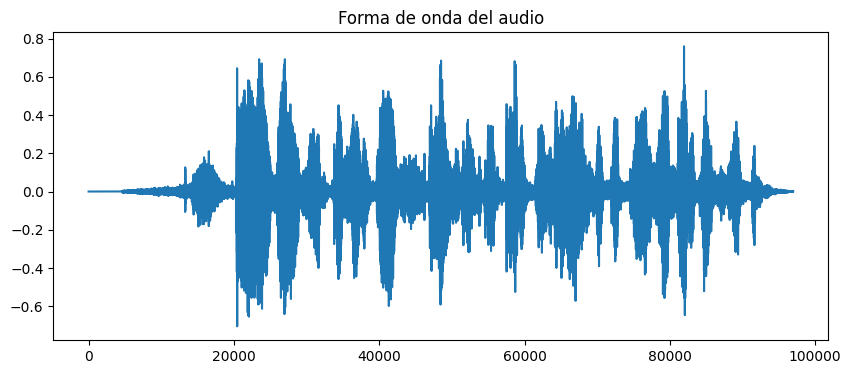

In [ ]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np

file_path = "/content/test.flac" # Tu archivo

try:
    data, samplerate = sf.read(file_path)
    print(f" Archivo cargado.")
    print(f"   Sample Rate: {samplerate}")
    print(f"   Forma (Shape): {data.shape}")
    print(f"   Valor Máximo (Volumen): {np.max(np.abs(data)):.4f}")

    if np.max(np.abs(data)) < 0.01:
        print(" El audio parece ser silencio puro o volumen muy bajo.")

    # Graficar para ver si hay onda
    plt.figure(figsize=(10, 4))
    plt.plot(data)
    plt.title("Forma de onda del audio")
    plt.show()

except Exception as e:
    print(f" Error al leer el archivo: {e}")